In [5]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from gymnasium import Env
from gymnasium.spaces import Box
import pyarrow as pa
import pyarrow.parquet as pq

In [15]:
class Architecture:
    def __init__(self):
        self.space_flag = 0
        self.c_capacity, self.s_capacity = 1000, 100                                         # Capacity of the devices
        # self.a1, self.a2, self.a3, self.mc = 0.000125, 0.000010, 0.000200, 0.001           # Weight of every type of data
        self.weights = [0.0125, 0.0010, 0.0200, 0.1000]                                      # a1, a2, a3, mc
        self.lifetime = {'a1': 10000, 'a2': 20000, 'a3': 10000, 'mc': 1000}                  # Max lifetime of the different data types
        self.total_c = 2
        self.total_s = 6
        self.max_actions = 20

        self.devices = {}
        self.data = {
            'a1': {},
            'a2': {},
            'a3': {},
            'mc': {},
        }
        self.latencies = {}

        for i in range(self.total_c):
            for j in (self.data.keys()):
                self.data[j]['c'+str(i)] = 0
            self.devices['c'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['c'+str(i)] = {}
        for i in range(self.total_s):
            for j in (self.data.keys()):
                self.data[j]['s'+str(i)] = 0
            self.devices['s'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['s'+str(i)] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data_allocation_dict = []

        self.action_type = []
        self.action_device_dev = []
        self.action_device = []

        randomized = list(self.devices.keys())
        random.shuffle(randomized)

        bound = round(len(self.devices)/4)

        self.clusters = {
            'a1': randomized[:bound],
            'a2': randomized[bound:bound*2],
            'a3': randomized[bound*2:bound*3],
            'mc': randomized[bound*3:]
        }

        self.visualization()

    def to_int(self, device):
        return list(self.devices.keys()).index(device)

    def to_device(self, position):
        return list(self.devices.keys())[position]

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation_dict,self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation_dict.append(device)
        self.data_allocation.append(self.to_int(device))
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation_dict[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation_dict[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation_dict.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in self.devices.keys():
            if list(i)[0] == 'c':
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= 0.2:
                self.space_flag = i
        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.total_c]
        ss = keys[self.total_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.total_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.total_c)+len(ss)%self.total_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device_dev[i]].values())])
        return total_latency

    def generate(self, operation):
        if operation == 'a1' or operation == 'a2' or operation == 'a3':
            for i in self.devices.keys():
                self.update(operation,i)
        elif operation == 'mc':
            for i in self.devices.keys():
                if list(i)[0] == 's':
                    self.update('mc',i)
        elif operation.split('_')[0] == 'ai':
            device=random.sample(list(self.clusters[operation.split('_')[1]]),1)
            self.action_device_dev.append(device[0])
            self.action_device.append(self.to_int(device[0]))
            self.action_type.append(operation.split('_')[1])
            difference = len(self.action_device_dev) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device_dev.pop(0)
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def greedy_algorithm(self): # baseline?
        if self.space_flag == 0:
            allocation = []
            allocation_dev = []
            for i in self.data_types:
                allocation.append(self.to_int(random.sample(list(self.clusters[i]),1)[0]))
                allocation_dev.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.data_allocation_dict = allocation_dev
            self.construct_dictionaries()
            result = self.free_space()
        else:
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            self.clusters[problematic_key].extend(element for element in self.devices if element[0]==('c'))
            self.space_flag = 0
            result = self.greedy_algorithm()

        return result

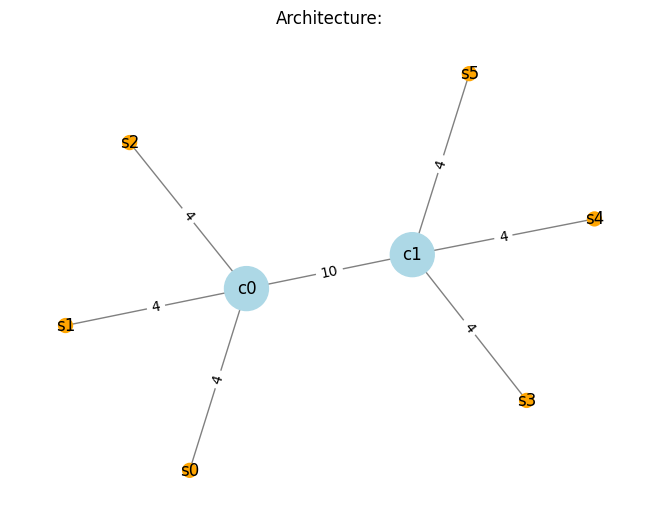

2

In [3]:
arch = Architecture()
list(arch.devices.keys()).index("s0")

In [7]:
class SimulatedArchitecture(Env):
    def __init__(self, architecture, num_devices):
        self.arch = architecture
        self.num_devices = num_devices
        self.weights = arch.weights
        self.free_space = list(arch.free_space().values())
        self.reward = 0
        self.executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']
        self.len_executions = len(self.executions)
        self.index = 0
    def get_obs(self):
        return {"weights": self.weights,
                "free_space": self.free_space,
                "allocation": self.allocation,
                "last_calls": self.last_calls
                }
    def step(self, action):
        latency = self.arch.compute_total_latency()
        self.free_space = list(self.arch.free_space().values())
        self.reward = 0

        for i in self.free_space:
            if i <= 0.2:
                self.reward = -1
                break

        if self.reward != -1:
            self.reward = 4000000*(1/(latency+1)) + 0.5*(1/(np.std(self.free_space)+0.00001))              # With those weights, the scale of both latency and std is the same for high values while the latency is the only one taken into account in initial states (when there is plenty of space in the system and distribution is not that important)
        info = {}
        done = True

        return self.get_obs(), self.reward, done, info

    def render(self):
        pass
    def reset(self):
        if self.reward != -1:
            self.arch.generate(self.executions[self.index])
            self.arch.heart_beat()
            self.index = self.index + 1 if self.index < self.len_executions-1 else 0
        self.allocation = [self.arch.data_types,self.arch.data_allocation]
        self.last_calls = [self.arch.action_type,self.arch.action_device]
        self.action_space = Box(low=0, high=self.num_devices-1, shape=(len(self.allocation[1]),), dtype=np.int16)
    def close(self):
        pass

In [4]:
# for i in range(1000):
#     simulation = SimulatedArchitecture(arch, 8)
#     simulation.reset()
#     simulation.step(simulation.allocation[1])
simulation = SimulatedArchitecture(arch, 8)
simulation.reset()
simulation.step(simulation.allocation[1])
len(simulation.last_calls[0])

NameError: name 'simulation' is not defined

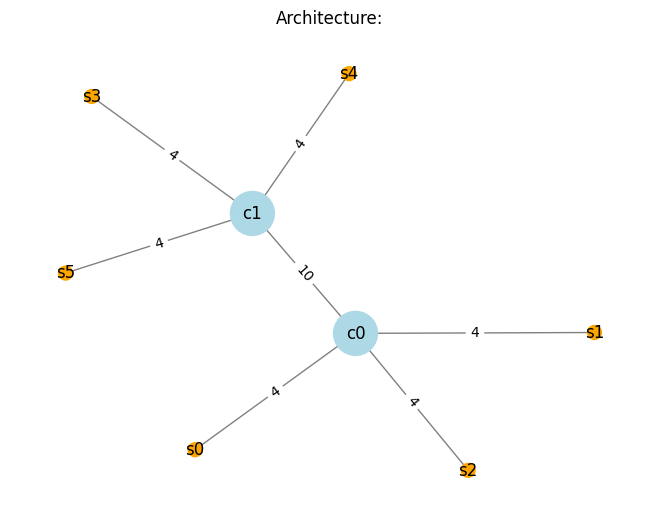

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [29:38<00:00,  1.78s/it]


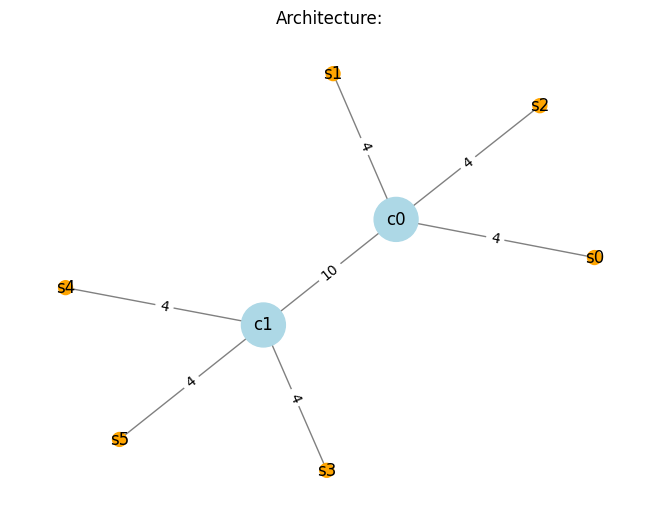

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [29:52<00:00,  1.79s/it]


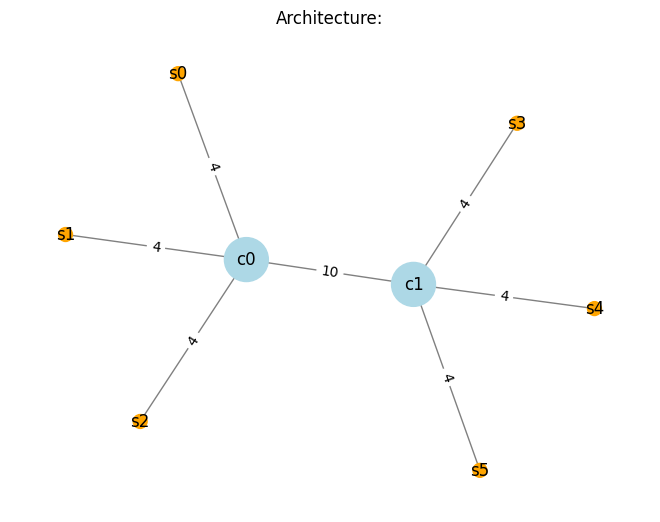

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [29:57<00:00,  1.80s/it]


In [16]:
import copy
import json

executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']

offline_dataset = {
    "observations": [],
    "actions": [],
    "rewards": [],
    "next_observations": []
}

for i in range(3):
    architecture = Architecture()
    free_space = list(architecture.free_space().values())
    for j in tqdm(range(1000)):
        for k in executions:
            observations = {
                "weights": [0.0125, 0.0010, 0.0200, 0.1000],
                "free_space": copy.copy(free_space),
                "allocation": [copy.copy(architecture.data_types), copy.copy(architecture.data_allocation)],
                "last_calls": [copy.copy(architecture.action_type), copy.copy(architecture.action_device)]
            }
            architecture.generate(k)
            architecture.heart_beat()
            free_space = copy.copy(list(architecture.greedy_algorithm().values()))
            action = copy.copy(architecture.data_allocation)
            latency = architecture.compute_total_latency()
            reward = 4000000*(1/(latency+1)) + 0.5*(1/(np.std(free_space)+0.00001))
            offline_dataset["observations"].append(observations)
            offline_dataset["actions"].append(copy.copy(action))
            offline_dataset["rewards"].append(copy.copy(reward))
            offline_dataset["next_observations"].append({
                "weights": [0.0125, 0.0010, 0.0200, 0.1000],
                "free_space": copy.copy(free_space),
                "allocation": [copy.copy(architecture.data_types), copy.copy(architecture.data_allocation)],
                "last_calls": [copy.copy(architecture.action_type), copy.copy(architecture.action_device)]
            })

# dataset_json = json.dumps(offline_dataset)
#
# file_path = 'TFM/offline_dataset.json'
#
# with open(file_path, 'w') as file:
#     file.write(dataset_json)

In [17]:
offline_next_observations = offline_dataset['next_observations']

offline_next_observations_pd = pd.DataFrame(offline_next_observations)

free_space = pd.DataFrame(columns=['c0','c1','s0','s1','s2','s3','s4','s5'])
for i in tqdm(list(offline_next_observations_pd['free_space'])):
    free_space.loc[len(free_space)] = i
ids = free_space[(free_space<=0.2).any(axis=1)]
for i in ids.index:
    offline_dataset["rewards"][i] = -1

directory_path = 'TFM/'

offline_next_observations_file_name = 'next_observations.csv'

offline_next_observations_file_path = directory_path + offline_next_observations_file_name

offline_next_observations_pd.to_csv(offline_next_observations_file_path, index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63000/63000 [01:08<00:00, 925.55it/s]


In [18]:
# Assuming you have an array called 'data'
offline_reward = offline_dataset['rewards']
offline_action = offline_dataset['actions']

# Convert the array to a PyArrow array
offline_reward_pa = pa.array(offline_reward)
offline_action_pa = pa.array(offline_action)

# Create a PyArrow table from the array
offline_reward_table = pa.Table.from_arrays([offline_reward_pa], names=['rewards'])
offline_action_table = pa.Table.from_arrays([offline_action_pa], names=['actions'])

# Specify the Parquet file name
offline_reward_file_name = 'rewards.parquet'
offline_action_file_name = 'actions.parquet'

# Combine the directory path and file name
offline_reward_file_path = directory_path + offline_reward_file_name
offline_action_file_path = directory_path + offline_action_file_name

# Write the table to a Parquet file at the specified location
pq.write_table(offline_reward_table, offline_reward_file_path)
pq.write_table(offline_action_table, offline_action_file_path)

In [22]:
offline_observations = offline_dataset['observations']

offline_observations_pd = pd.DataFrame(offline_observations)
offline_observations_pd.loc[0]['free_space']

offline_observations_file_name = 'observations.csv'

offline_observations_file_path = directory_path + offline_observations_file_name

offline_observations_pd.to_csv(offline_observations_file_path, index=False)

In [18]:
# file_path = 'TFM/offline_dataset.json'
#
# with open(file_path) as json_file:
#     offline_dataset = json.load(json_file)

In [ ]:
executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']

free_spaces200 = pd.DataFrame(columns=['c0','c1','s0','s1','s2','s3','s4','s5'])
latencies200 = pd.Series()

for j in tqdm(range(1000)):
    for i in executions:
        arch.generate(i)
        arch.heart_beat()
        free_spaces200.loc[len(free_spaces200)] = list(arch.greedy_algorithm().values())
        latencies200.loc[len(latencies200)] = arch.compute_total_latency()
print(arch.compute_total_latency())

In [19]:
offline_dataset_test = copy.copy(offline_dataset)
analysis = pd.DataFrame(columns=['c0','c1','s0','s1','s2','s3','s4','s5'])
for i in range(len(offline_dataset_test["observations"])):
    analysis.loc[len(analysis)] = offline_dataset_test["observations"][i]["free_space"]

In [25]:
ids = analysis[(analysis<=0.2).any(axis=1)]
for i in ids.index:
    # offline_dataset_test["rewards"][i] = -1
    print(offline_dataset_test["rewards"][i])

-1
-1
-1
-1
-1
-1


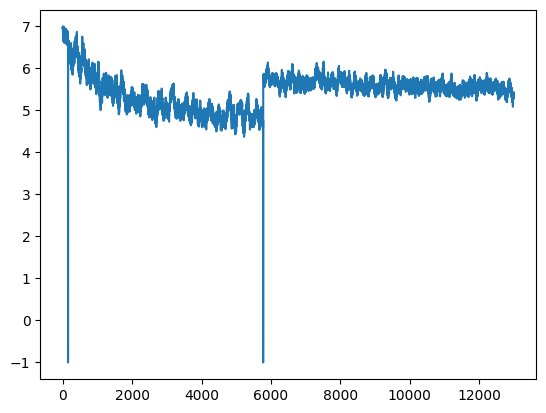

In [53]:
plt.plot(offline_dataset["rewards"][8000:21000])